In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import statsmodels.api as sm

In [4]:
np.random.seed(0)
a = np.random.rand(100)
b = np.random.rand(100)
c = np.random.rand(100)
u = np.random.rand(100)

In [5]:
y = 1.5*a + -1*b + 0.5*c + u

In [6]:
df = pd.DataFrame(zip(y, a, b, c), columns=['y', 'a', 'b', 'c'])

In [7]:
df.head()

,y,a,b,c
0,1.207857,0.548814,0.677817,0.311796
1,1.924995,0.715189,0.270008,0.696343
2,0.690972,0.602763,0.735194,0.377752
3,0.026039,0.544883,0.962189,0.179604
4,0.806310,0.423655,0.248753,0.024679


<AxesSubplot:ylabel='Frequency'>

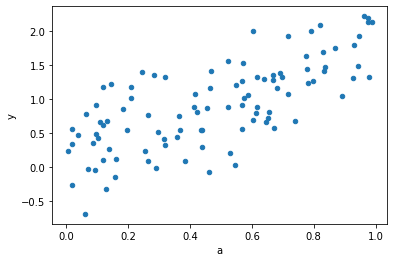

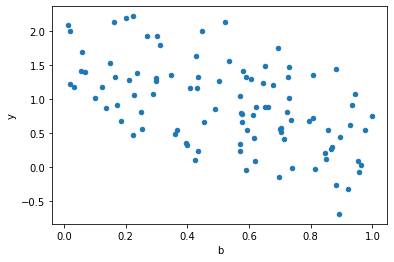

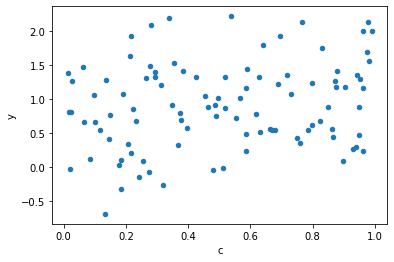

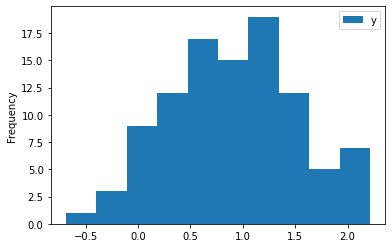

In [8]:
df.plot(kind='scatter', x='a', y='y')
df.plot(kind='scatter', x='b', y='y')
df.plot(kind='scatter', x='c', y='y')
df.plot(kind='hist', y='y')

# パッケージ

In [9]:
gamma_model = sm.GLM(df['y'], df[[ 'a', 'b', 'c']], family=sm.families.Gaussian())

In [10]:
gamma_results = gamma_model.fit()
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.10997
Method:                          IRLS   Log-Likelihood:                -29.994
Date:                Sat, 25 Jun 2022   Deviance:                       10.667
Time:                        15:12:10   Pearson chi2:                     10.7
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9267
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a              1.8220      0.097     18.757      0.0

# 解析的に解く
- 損失関数はMSE

$$
    L(\beta_1, \beta_2) = (Y-\hat{Y})^2, \hat{Y} = \beta_1x_1 + \beta_2x_2
$$
$$
    \frac{dL}{d\beta_1} = 0, \frac{dL}{d\beta_2} = 0 の連立方程式を解くと\beta_1 = (X^TX)^{-1}X^TY
$$

In [11]:
X = df[[ 'a', 'b', 'c']].values
Y = df['y'].values

In [12]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
print(beta)

[ 1.82201207 -0.68333236  0.70681036]


# 損失関数をMSEとして解く
- 最急降下法
- SGD
- ニュートン法

損失関数をMSEとした時、1階微分は以下。
$$
    \frac{dL}{d\beta_1} = -\sum_{i}^n (y_i-\hat{y_i})x_{1i}
$$
パラメータの更新式は以下。これの更新幅が小さくなるまで更新を繰り返す。(kは更新回数)
$$
    \beta_1^{(k+1)} = \beta_1^{k} - \alpha\frac{dL}{d\beta_1}
$$
最急降下法は全サンプルを使って勾配を計算する。SGDは1サンプル毎に勾配を計算してパラメータを更新する。(ミニバッチがこの2つの間)

ニュートン法では2階微分も使う。
$$
    \frac{dL}{d\beta_1\beta_1} = \sum_i^n x_{1i}^2, \frac{dL}{d\beta_1\beta_2} = \sum_i^n x_{1i}x_{2i}
$$
ヘッセ行列(=フィッシャー情報行列)は以下。
$$
    H = \begin{pmatrix}
    \frac{dL}{d\beta_1\beta_1}&\frac{dL}{d\beta_1\beta_2}\\
    \frac{dL}{d\beta_1\beta_2}&\frac{dL}{d\beta_2\beta_2}
    \end{pmatrix}
$$
パラメータの更新式は以下。これの更新幅が小さくなるまで更新を繰り返す。(kは更新回数)
$$
    \beta_1^{(k+1)} = \beta_1^{k} - H^{-1}\frac{dL}{d\beta_1}
$$


In [13]:
def mse(Y, Y_hat):
    return np.sum((Y-Y_hat)**2)

### 最急降下法

In [14]:
alpha = 0.01

In [15]:
def mse_grad(Y, X, beta):
    Y_hat = np.sum(X*beta, axis=1)
    return -np.sum((Y - Y_hat).reshape(-1, 1)*X, axis=0)

In [16]:
# 初期化
np.random.seed(0)
init_beta = np.random.rand(3)
print("初期パラメータ: ", init_beta)

初期パラメータ:  [0.5488135  0.71518937 0.60276338]


In [17]:
beta = init_beta
# パラメータ更新
beta_result = []
loss_result = []
for i in range(50):
    beta = beta - alpha*mse_grad(Y, X, beta)
    Y_hat = np.sum(X*beta, axis=1)
    # save
    beta_result.append(list(beta))
    loss_result.append([i, mse(Y, Y_hat)])
print("パラメータ: ", beta)
beta_result = np.array(beta_result)
loss_result = np.array(loss_result)

パラメータ:  [ 1.80578075 -0.66910581  0.70735958]


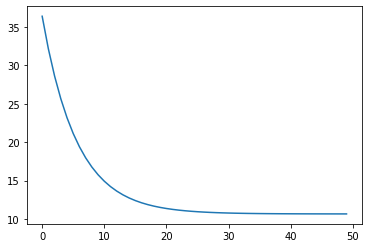

In [18]:
# loss関数の推移
plt.plot(loss_result[:, 0], loss_result[:, 1])

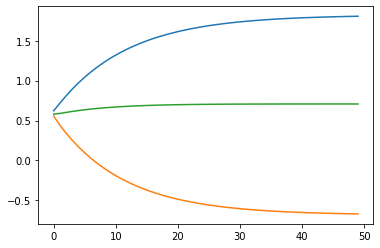

In [19]:
# パラメータの推移
plt.plot(loss_result[:, 0], beta_result[:, 0])
plt.plot(loss_result[:, 0], beta_result[:, 1])
plt.plot(loss_result[:, 0], beta_result[:, 2])

### SGD

In [20]:
# 1サンプルに対して勾配を計算する
def mse_grad_sgd(y, x, beta):
    y_hat = np.sum(x*beta)
    return -(y-y_hat)*x

In [21]:
# 初期化
np.random.seed(0)
init_beta = np.random.rand(3)
print("初期パラメータ: ", init_beta)

初期パラメータ:  [0.5488135  0.71518937 0.60276338]


In [22]:
beta = init_beta
# パラメータ更新
beta_result = []
loss_result = []
for i in range(100):
    for x, y in zip(X, Y):
        beta = beta - alpha*mse_grad_sgd(y, x, beta)
        Y_hat = np.sum(X*beta, axis=1)
        # save
        beta_result.append(list(beta))
        loss_result.append([i, mse(Y, Y_hat)])
print("パラメータ: ", beta)
beta_result = np.array(beta_result)
loss_result = np.array(loss_result)

パラメータ:  [ 1.82948036 -0.66473456  0.71696592]


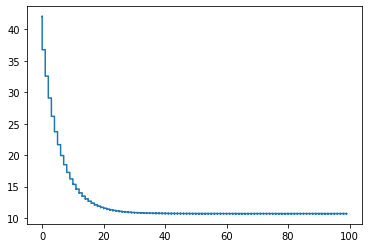

In [23]:
# loss関数の推移
plt.plot(loss_result[:, 0], loss_result[:, 1])

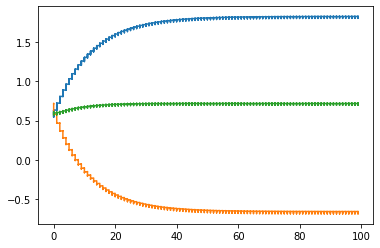

In [24]:
# パラメータの推移
plt.plot(loss_result[:, 0], beta_result[:, 0])
plt.plot(loss_result[:, 0], beta_result[:, 1])
plt.plot(loss_result[:, 0], beta_result[:, 2])

### ニュートン法

In [25]:
# 1サンプルに対してhessを計算する
def mse_hess_sgd(x):
    return x.reshape(-1, 1).dot(x.reshape(1, -1))

In [26]:
def mse_hess(X):
    hess = np.zeros((X.shape[1], X.shape[1]))
    for x in X:
        hess += mse_hess_sgd(x)
    return hess

In [27]:
# 初期化
np.random.seed(0)
init_beta = np.random.rand(3)
print("初期パラメータ: ", init_beta)
init_loss = mse(y, np.sum(X*init_beta, axis=1))

初期パラメータ:  [0.5488135  0.71518937 0.60276338]


In [28]:
beta = init_beta
# パラメータ更新
beta_result = [list(init_beta)]
loss_result = [[0, init_loss]]
for i in range(10):
    grad = mse_grad(Y, X, beta)
    hess = mse_hess(X)
    beta = beta - (np.linalg.inv(hess).dot(grad))
    Y_hat = np.sum(X*beta, axis=1)
    # save
    beta_result.append(list(beta))
    loss_result.append([i+1, mse(Y, Y_hat)])
print("パラメータ: ", beta)
beta_result = np.array(beta_result)
loss_result = np.array(loss_result)

パラメータ:  [ 1.82201207 -0.68333236  0.70681036]


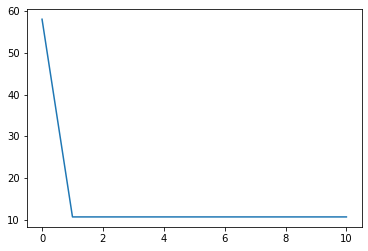

In [29]:
# loss関数の推移
plt.plot(loss_result[:, 0], loss_result[:, 1])

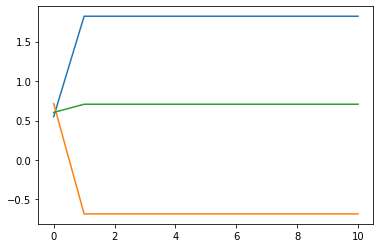

In [30]:
# パラメータの推移
plt.plot(loss_result[:, 0], beta_result[:, 0])
plt.plot(loss_result[:, 0], beta_result[:, 1])
plt.plot(loss_result[:, 0], beta_result[:, 2])